In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Clickea aquí para ver u ocultar el código."></form>''')

In [2]:
import glob
import os
import pickle
from scipy.stats import bernoulli

!pip install --upgrade geopandas
import geopandas as gpd
from shapely.geometry import Point

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
from xgboost import XGBRegressor

import xgboost as xgb
import scipy.stats as st

from google.colab import drive
# mount google drive information in a google colaboratory directory
drive.mount('/content/gdrive')

path = r'gdrive/My Drive/Trabajos DS/Data/' # path

     |████████████████████████████████| 1.0MB 8.0MB/s 
     |████████████████████████████████| 15.3MB 277kB/s 
     |████████████████████████████████| 6.5MB 40.1MB/s 
Mounted at /content/gdrive


### **4. Exploratoy Data Analysis**

**Final Data Load**

In [3]:
# Load dataframe from pickled pandas object
file_name = path+'dataset_olist.pkl'
df_final= pd.read_pickle(file_name)
print('Shape of Dataset: ', df_final.shape[0], 'rows and', df_final.shape[1], 'columns')
df_final.head(3)

Shape of Dataset:  96470 rows and 22 columns


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,total_price,total_freight_value,distinct_product_order,total_weight,total_volume,isfragile,all_same_city,all_same_state,max_distance,customer_city_reduced,customer_state_reduced,percentage_freight_price,diff_customer_estimated_num,delayed,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,2017-10-10,2017-10-18,3149,sao paulo,SP,29.99,8.72,1,500.0,1976.0,1,0,1,18.566632,sao paulo,SP,0.225265,-8,0,10
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,2018-08-07,2018-08-13,47813,barreiras,BA,118.70,22.76,1,400.0,4693.0,1,0,0,847.437333,Other,BA,0.160894,-6,0,7
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08,2018-08-17,2018-09-04,75265,vianopolis,GO,159.90,19.22,1,420.0,9576.0,0,0,0,512.100044,Other,GO,0.107302,-18,0,8


In [4]:
columns_X = ['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date',
           'order_estimated_delivery_date', 'customer_city', 'customer_state', 'total_price', 'total_freight_value',
           'distinct_product_order', 'total_weight', 'total_volume', 'isfragile',
           'all_same_city', 'all_same_state', 'max_distance',
           'customer_city_reduced', 'customer_state_reduced',
           'percentage_freight_price',
           'purchase_month']

column_Y = ['delayed']

columns_categorical = ['customer_state','customer_city','isfragile','all_same_city', 'all_same_state']

columns_numerical = ['total_price', 'total_freight_value',
                   'distinct_product_order', 'total_weight', 'total_volume',
                   'max_distance','percentage_freight_price','purchase_month']

**Number of orders by target variable**

In [5]:
tmp = df_final.groupby(['delayed']).nunique()[['order_id']]
tmp['porc'] = df_final['delayed'].value_counts(normalize=True) * 100
tmp['Performance'] = np.where(tmp.index==0, 'Not Delayed', 'Delayed')
tmp.rename(columns={'order_id':'# Orders',
                    'porc':'% Orders'})

,# Orders,% Orders,Performance
delayed,,,
0,89936,93.22691,Not Delayed
1,6534,6.77309,Delayed


**Correlation Analysis - between the independent variables**

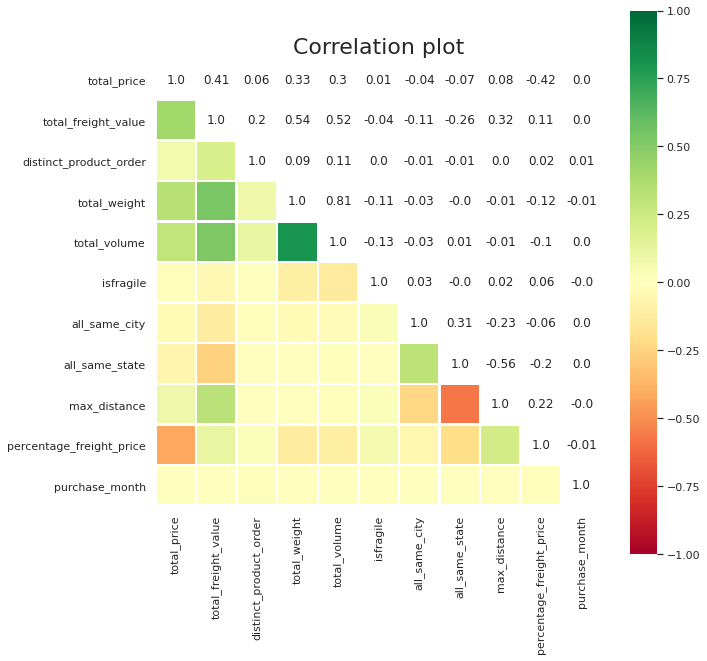

In [6]:
data = df_final[columns_X] #se toman solo variables numéricas

sns.set(style="white")
fig, ax = plt.subplots(1, figsize=(10, 10))
corr = data.corr()
labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.round(2)
labels = labels.replace(np.nan, ' ', regex=True)

mask = np.triu(np.ones(corr.shape)).astype(np.bool)
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='RdYlGn',
    fmt='',
    square=True,
    linewidths=1.5).set_title("Correlation plot", fontsize=22)
mask = np.ones(corr.shape) - mask
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=ListedColormap(['white']),
    annot=labels,
    cbar=False,
    fmt='',
    linewidths=1.5)

*Conclusion*   
The chart shows that some variables are correlated with some others:  

* The distance between sellers and customers (max_distance) has a positive correlation with the total freight value. This makes sense. The greater the distance between seller and customer, the higher the cost of freight. For the same reason, it has positive correlation with the percentage of freight price. 
* The distance between sellers and customers has a high negative correlation with the variable all_same_state. This also makes sense. If a customer and a seller live in the same state, the distance would be short. The same happens between the distance and all_same_city, but with less intensity, where there is negative correlation as the distance is short if a customer and seller live in the same city.
* The total price of the order is negatively correlated with the percentage of freight price. This means that the more expensive the order is, the less is the percentage that corresponds to freight. On the contrary, when the total price of the order is low, the percentage that corresponds to freight tends to be high.
* In reference to the size order variables, weigth and volume have a high positive correlation with the freight value. The bigger and heavier the order is, the higher the freight value is. This also is related to the positive correlation between the freight value and the number of distinct products that the order has. 
* The variables all_same_city and all_same_state are positively correlated. That means that if a customer lives in the same state as the seller, it is very likely that they also live in the same city.
* The total freight value has a negative correlation, although not very accentuated, with all_same_city and all_same_state. When the seller and customer do not live in the same state or city, the total freight value of the order is greater.


**Relation with Delayed variable - Categorical Variables**

States and % Orders, by Class (Delayed / Not Delayed)


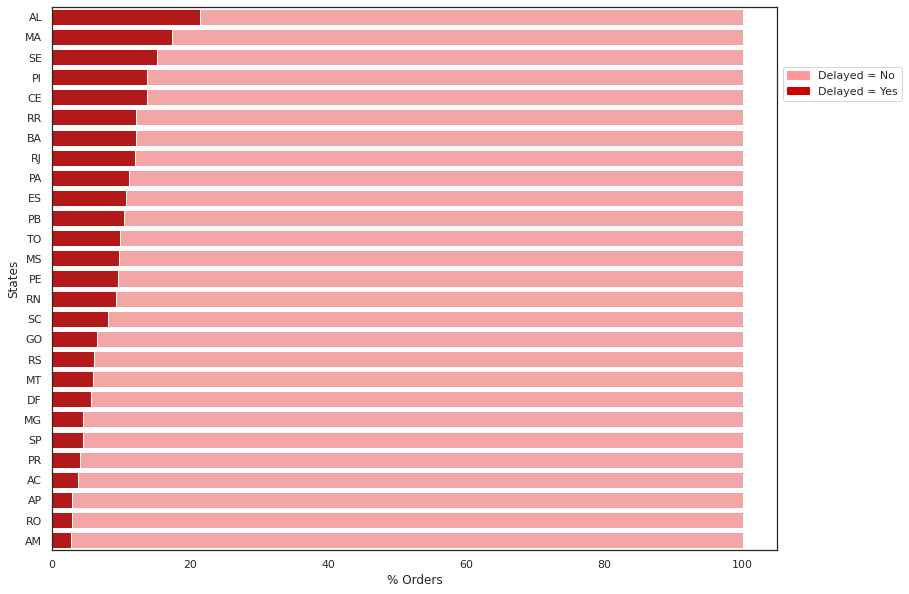

In [7]:
print('States and % Orders, by Class (Delayed / Not Delayed)')
## load dataset
tips = df_final.copy()

# set the figure size
plt.figure(figsize=(13, 10))

# from raw value to percentage
total = tips.groupby('customer_state')['order_id'].agg(['nunique']).reset_index()
delayed = tips[tips.delayed==1].groupby('customer_state')['order_id'].agg(['nunique']).reset_index()
delayed['nunique'] = [i / j * 100 for i,j in zip(delayed['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
total = total.sort_values('nunique', ascending=False)
delayed = delayed.sort_values('nunique', ascending=False)

# bar chart 1 -> top bars (group of 'delayed=No')
bar1 = sns.barplot(x="nunique",  y="customer_state", data=total, color='#ff9999')

# bar chart 2 -> bottom bars (group of 'delayed=Yes')
bar2 = sns.barplot(x="nunique", y="customer_state", data=delayed, color='#CC0000')

# add legend
top_bar = mpatches.Patch(color='#ff9999', label='Delayed = No')
bottom_bar = mpatches.Patch(color='#CC0000', label='Delayed = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='best', bbox_to_anchor=(1,0.9))
plt.xlabel("% Orders")
plt.ylabel("States")
# show the graph
plt.show()

In [8]:
# Load shapefile object
file_name = path+'bra_adm1/BRA_adm1.shp'
brazil_states= gpd.read_file(file_name)

map_br_states = brazil_states.copy()
map_br_states['state'] = brazil_states['HASC_1'].astype('str').str.split('.', expand=True)[[1]]
map_br_states.drop('HASC_1',axis=1, inplace=True)

tips = df_final.copy()
total = tips.groupby('customer_state')['order_id'].agg(['nunique']).reset_index()
delayed = tips[tips.delayed==1].groupby('customer_state')['order_id'].agg(['nunique']).reset_index()

d = pd.merge(total, delayed, how='inner', on='customer_state').sort_values('nunique_x', ascending=False)
d['porc_delay'] = d['nunique_y'] / d['nunique_x'] *100
d = d.sort_values('porc_delay', ascending=False)
d = d.set_index('customer_state')

d_porcdel = d[['porc_delay']]
map_br_states_graph = map_br_states.copy().set_index('state')
map_br_states_graph = pd.merge(map_br_states_graph, d_porcdel, how='inner', left_index=True, right_index=True)

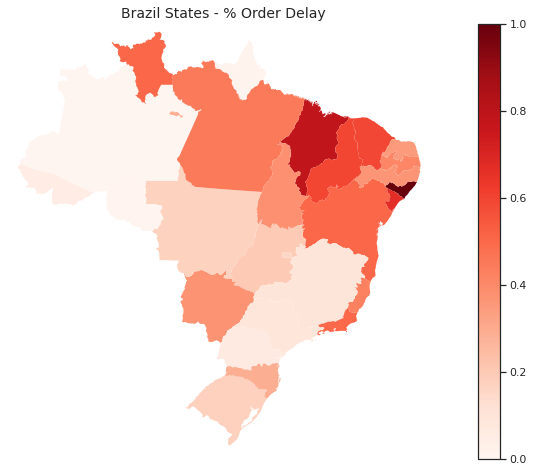

In [9]:
valor='porc_delay'

fig, ax = plt.subplots(1, figsize=(14, 8))
map_br_states_graph.plot(column=valor, cmap='Reds', linewidth=0, ax=ax, edgecolor='0.8')

ax.axis('off') #quitarle los ejes
ax.set_xlim(left=-75, right=-33)
ax.set_ylim(bottom=-35, top=6)
ax.set_title('Brazil States - % Order Delay', fontdict={'fontsize': '14', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [24]:
print('States table - Orders Count and % Delayed Orders')
d.rename(columns={'nunique_x':'Total Orders',
                 'nunique_y':'Delay Orders',
                 'porc_delay':'% Delayed Orders'})

States table - Orders Count and % Delayed Orders


,Total Orders,Delay Orders,% Delayed Orders
customer_state,,,
AL,397,85,21.410579
MA,717,125,17.433752
SE,335,51,15.223881
PI,476,66,13.865546
CE,1279,176,13.760751
RR,41,5,12.195122
BA,3256,396,12.162162
RJ,12350,1495,12.105263
PA,946,106,11.205074


These two charts shows that the AL is the state with the latest deliveries. It is followed by MA state and SE state.   
Whereas the AM, RO and AP are the 3 states with lowest percentage of delayed orders.    
Also, Sao Paulo (SP) and Parana (PR) have low percentage of order delays. This could be due to the Olist base location, Curitiba, which is in the PR state. Partners from the e-commerce company are maybe more efficient around this area.   
On the oder hand, in the table it is shown the real number of orders in each state, to get an idea of the relevance of each one. For instance, AM, RO, AP and AC have very low total orders and, therefore, low delayed orders. So, these might not be too relevant to be considered as favorable states in terms of efficency on delivery. On the contrary, SP has more than 40 thousand total order, from which only 4% were arrived out of the estimated time.

Cities and % Orders, by Class (Delayed / Not Delayed)


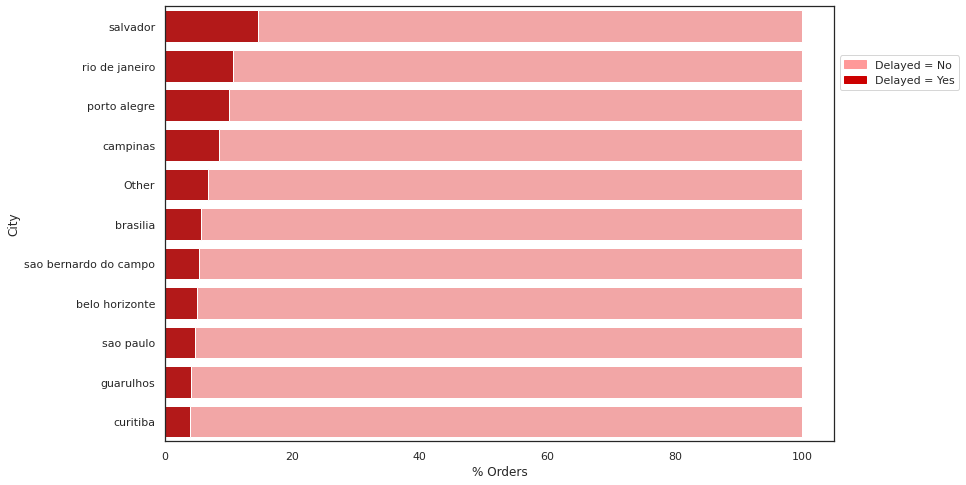

In [11]:
print('Cities and % Orders, by Class (Delayed / Not Delayed)')

# load dataset
tips = df_final.copy()

# set the figure size
plt.figure(figsize=(12, 8))

# from raw value to percentage
total = tips.groupby('customer_city_reduced')['order_id'].agg(['nunique']).reset_index()
delayed = tips[tips.delayed==1].groupby('customer_city_reduced')['order_id'].agg(['nunique']).reset_index()
delayed['nunique'] = [i / j * 100 for i,j in zip(delayed['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]

total = total.sort_values('nunique', ascending=False)
delayed = delayed.sort_values('nunique', ascending=False)

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="nunique",  y="customer_city_reduced", data=total, color='#ff9999')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="nunique", y="customer_city_reduced", data=delayed, color='#CC0000')

# add legend
top_bar = mpatches.Patch(color='#ff9999', label='Delayed = No')
bottom_bar = mpatches.Patch(color='#CC0000', label='Delayed = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='best', bbox_to_anchor=(1,0.9))
plt.xlabel("% Orders")
plt.ylabel("City")
# show the graph
plt.show()

Regarding the cities, it can be seen that the **Salvador** is the city with the most delayed deliveries.
It is followed by **Rio de Janeiro** and **Porto Alegre**. These 3 cities are among the most populated in Brazil. So this could be one of the reason about delay, the high demand for orders and, may be, without sufficient availability of delivery.   
On the contrary, Curitiba, Guarulhos and Sao Paulo are the cities with lowest percentage of delayed orders. Although Sao Paulo is the most populated city of Brazil, it is closed to Curitiba, the city where Olist is based. This might be one reason about its low percentage of delayed orders.

In [7]:
tips = df_final.copy()
total = tips.groupby('customer_city_reduced')['order_id'].agg(['nunique']).reset_index()
delayed = tips[tips.delayed==1].groupby('customer_city_reduced')['order_id'].agg(['nunique']).reset_index()

d = pd.merge(total, delayed, how='inner', on='customer_city_reduced').sort_values('nunique_x', ascending=False)
d['porc_delay'] = d['nunique_y'] / d['nunique_x'] *100
d = d.sort_values('porc_delay', ascending=False)
d = d.set_index('customer_city_reduced')

print('Cities table - Orders Count and % Delayed Orders')
d.rename(columns={'nunique_x':'Total Orders',
                 'nunique_y':'Delay Orders',
                 'porc_delay':'% Delayed Orders'})

Cities table - Orders Count and % Delayed Orders


,Total Orders,Delay Orders,% Delayed Orders
customer_city_reduced,,,
salvador,1188,174,14.646465
rio de janeiro,6601,706,10.695349
porto alegre,1341,136,10.141685
campinas,1406,119,8.463727
Other,62578,4273,6.828278
brasilia,2071,118,5.697731
sao bernardo do campo,911,49,5.378705
belo horizonte,2697,137,5.079718
sao paulo,15045,715,4.752409


Fragile attribute and % Orders, by Class (Delayed / Not Delayed)


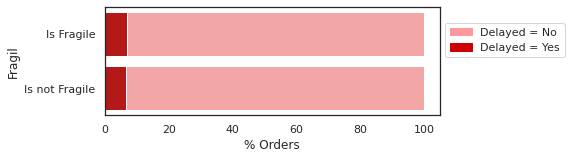

In [12]:
print('Fragile attribute and % Orders, by Class (Delayed / Not Delayed)')

# load dataset
tips = df_final.copy()
tips['isfragile'] = np.where(tips['isfragile']==1, 'Is Fragile', 'Is not Fragile')
# set the figure size
plt.figure(figsize=(6, 2))

# from raw value to percentage
total = tips.groupby('isfragile')['order_id'].agg(['nunique']).reset_index()
delayed = tips[tips.delayed==1].groupby('isfragile')['order_id'].agg(['nunique']).reset_index()
delayed['nunique'] = [i / j * 100 for i,j in zip(delayed['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="nunique",  y="isfragile", data=total, color='#ff9999')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="nunique", y="isfragile", data=delayed, color='#CC0000')

# add legend
top_bar = mpatches.Patch(color='#ff9999', label='Delayed = No')
bottom_bar = mpatches.Patch(color='#CC0000', label='Delayed = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='best', bbox_to_anchor=(1,0.9))
plt.xlabel("% Orders")
plt.ylabel("Fragil")
# show the graph
plt.show()

In this chart, it is possible to see that there is no such a difference on delay or not delay of orders if the product or products on which it consists are fragil or not. This variable does not appear to be defining in terms of delivery delay.

Same or different state of sellers and customers, by Class (Delayed / Not Delayed)


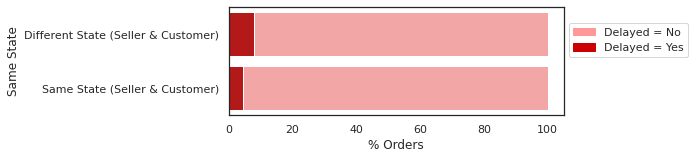

In [13]:
print('Same or different state of sellers and customers, by Class (Delayed / Not Delayed)')

# load dataset
tips = df_final.copy()
tips['all_same_state'] = np.where(tips['all_same_state']==1, 'Same State (Seller & Customer)', 'Different State (Seller & Customer)')
# set the figure size
plt.figure(figsize=(6, 2))

# from raw value to percentage
total = tips.groupby('all_same_state')['order_id'].agg(['nunique']).reset_index()
delayed = tips[tips.delayed==1].groupby('all_same_state')['order_id'].agg(['nunique']).reset_index()
delayed['nunique'] = [i / j * 100 for i,j in zip(delayed['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="nunique",  y="all_same_state", data=total, color='#ff9999')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="nunique", y="all_same_state", data=delayed, color='#CC0000')

# add legend
top_bar = mpatches.Patch(color='#ff9999', label='Delayed = No')
bottom_bar = mpatches.Patch(color='#CC0000', label='Delayed = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='best', bbox_to_anchor=(1,0.9))
plt.xlabel("% Orders")
plt.ylabel("Same State")
# show the graph
plt.show()

In this graph it can be seen that the fact that sellers and customers live in different states affects the delay of the order

Same or different cities of sellers and customers, by Class (Delayed / Not Delayed)


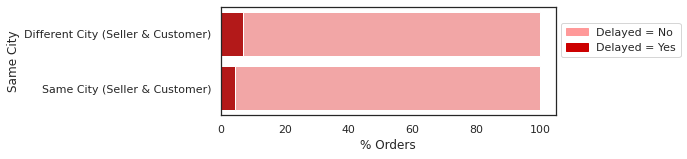

In [14]:
print('Same or different cities of sellers and customers, by Class (Delayed / Not Delayed)')

# load dataset
tips = df_final.copy()
tips['all_same_city'] = np.where(tips['all_same_city']==1, 'Same City (Seller & Customer)', 'Different City (Seller & Customer)')
# set the figure size
plt.figure(figsize=(6, 2))

# from raw value to percentage
total = tips.groupby('all_same_city')['order_id'].agg(['nunique']).reset_index()
delayed = tips[tips.delayed==1].groupby('all_same_city')['order_id'].agg(['nunique']).reset_index()
delayed['nunique'] = [i / j * 100 for i,j in zip(delayed['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="nunique",  y="all_same_city", data=total, color='#ff9999')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="nunique", y="all_same_city", data=delayed, color='#CC0000')

# add legend
top_bar = mpatches.Patch(color='#ff9999', label='Delayed = No')
bottom_bar = mpatches.Patch(color='#CC0000', label='Delayed = Yes')
plt.legend(handles=[top_bar, bottom_bar], loc='best', bbox_to_anchor=(1,0.9))
plt.xlabel("% Orders")
plt.ylabel("Same City")
# show the graph
plt.show()

In this graph, as well as the previous one, it can be seen that the fact that sellers and customers live in different cities affects the delay of the order.   
However, the effect is less critical than in the state case.

**Relation with Delayed variable - Numerical Variables**

Distance Seller and Customer vs Number of distincts product, by Class


<Figure size 432x288 with 0 Axes>

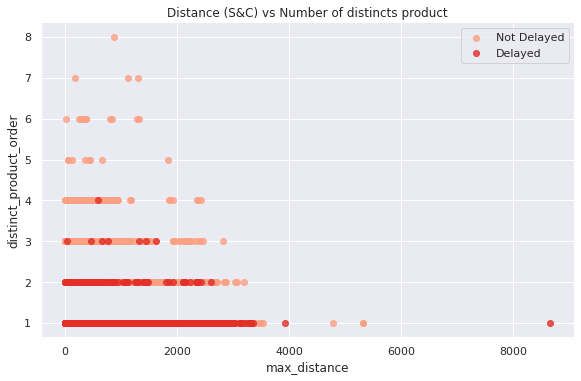

In [15]:
print('Distance Seller and Customer vs Number of distincts product, by Class')
data = df_final.copy()
data['delayed'] = np.where(data['delayed']==1, 'Delayed', 'Not Delayed')
plt.figure(figsize=(6,4))
sns.set()
sns.lmplot( x='max_distance', y='distinct_product_order', data=data, fit_reg=False, hue='delayed', legend=False,aspect=1.6, palette='Reds') 
plt.title('Distance (S&C) vs Number of distincts product')
plt.legend(loc='upper right');


It can be seen that order delays occur more often when the quantity of distinct products is small.   
Also, the greater the distance, the more cases of delay.

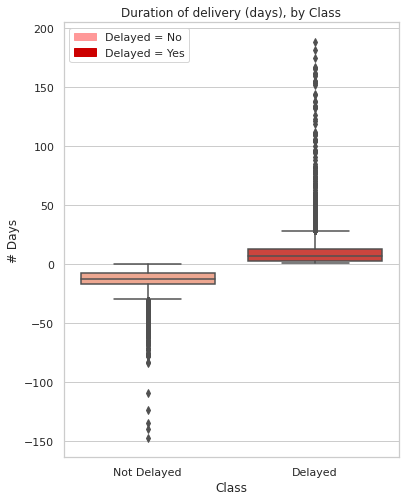

In [16]:
# print('Duration of delivery (days), by Class')
data = df_final.copy()
data['delayed'] = np.where(data['delayed']==1, 'Delayed', 'Not Delayed')
plt.figure(figsize=(6,8))
sns.set_theme(style="whitegrid")
sns.boxplot(y='diff_customer_estimated_num', x='delayed', data=data, palette='Reds')
top_bar = mpatches.Patch(color='#ff9999', label='Delayed = No')
bottom_bar = mpatches.Patch(color='#CC0000', label='Delayed = Yes')
plt.title('Duration of delivery (days), by Class')
plt.xlabel("Class")
plt.ylabel("# Days")
plt.legend(handles=[top_bar, bottom_bar],loc='upper left');


The number of days it takes for freight to deliver an order differs depending on whether the order has been delivered on time or not.    
In cases of delivery out of time (**delayed**), the number of days of waiting is concentrated around 15 or 20. While in cases of delivery on time (**not delayed**), an order arrives between 15 and 20 days before the estimated arrival day.   
There are outliers in both cases as can be seen. In cases of deadline deliveries, near 200 days is the maximum wait.

**Number of orders by Month, Delayed and Not Delayed**

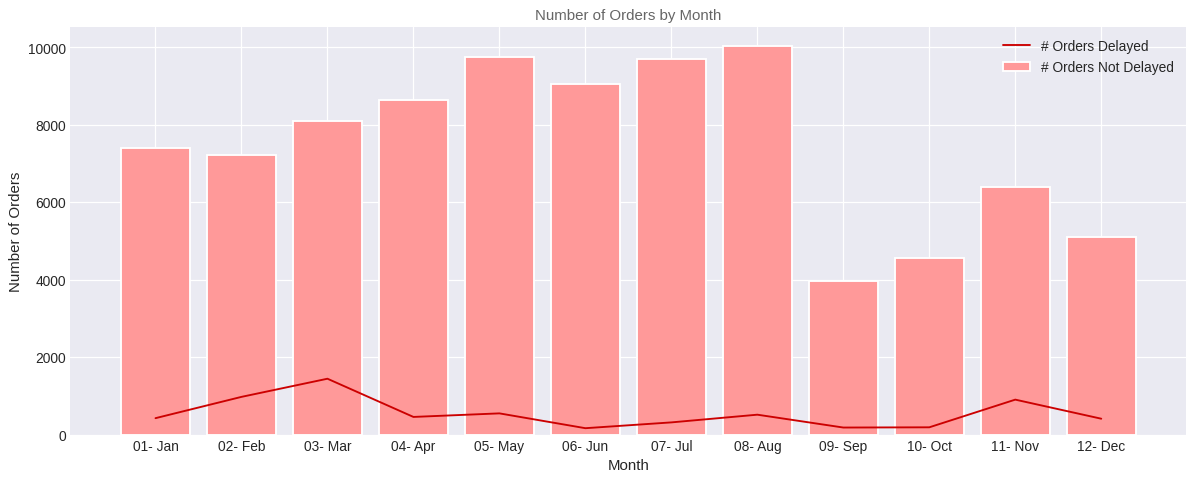

In [17]:
from matplotlib import pyplot
df_final['Month'] = np.where(df_final['purchase_month']==1, '01- Jan', 
                             np.where(df_final['purchase_month']==2, '02- Feb', 
                                      np.where(df_final['purchase_month']==3, '03- Mar',
                                               np.where(df_final['purchase_month']==4, '04- Apr',
                                                        np.where(df_final['purchase_month']==5, '05- May',
                                                                 np.where(df_final['purchase_month']==6, '06- Jun',
                                                                          np.where(df_final['purchase_month']==7, '07- Jul',
                                                                                   np.where(df_final['purchase_month']==8, '08- Aug',
                                                                                            np.where(df_final['purchase_month']==9,'09- Sep',
                                                                                                     np.where(df_final['purchase_month']==10,'10- Oct',
                                                                                                              np.where(df_final['purchase_month']==11, '11- Nov', '12- Dec')))))))))))
df = df_final.groupby(['Month','delayed']).agg({'order_id': 'nunique'}).unstack()
plt.style.use('seaborn-darkgrid')

fig = pyplot.figure(1, figsize=(16,6), dpi=90)
ax = fig.add_subplot(111)

X = df.reset_index()[(     'Month','')]
#X = df.reset_index()['OPT_MONTH']
C, S = df[('order_id', 0)], df[('order_id', 1)]


# Graficar revenue
plt.bar(X, C, color="#ff9999", linewidth=1.5, linestyle="-", label='# Orders Not Delayed'),
# Graficar revenue
plt.plot(X, S, color="#CC0000", linewidth=1.5, linestyle="-", label='# Orders Delayed')

plt.legend(loc='upper right')
plt.title("Number of Orders by Month", loc='center', fontsize=12, fontweight=0, color='#666666')
plt.xlabel("Month")
plt.ylabel("Number of Orders");

**March**, **May**, **August** and **November** where the months with more delayed orders, taking into account years 2016, 2017 and 2018.
It seems that once every other month, delays increase.   
In March case, a probable reason for the high number of orders might be easter time in the end of the month and the beginning of April.   
In November case, this could be justified with holidays, as christmas time and new year, where a lot of people tends to do shopping.

In [18]:
# Convert strings to datetime
df_final['order_purchase_timestamp_'] = pd.to_datetime(df_final.order_purchase_timestamp.astype(str),
                                              format='%Y/%m/%d %H:%M:%S')
# create colunms for date(day/month/year),
# year, month, week, and weekday name
df_final['OPT_YEAR'] = df_final.order_purchase_timestamp_.dt.year
df_final = df_final.drop('order_purchase_timestamp_', axis=1)

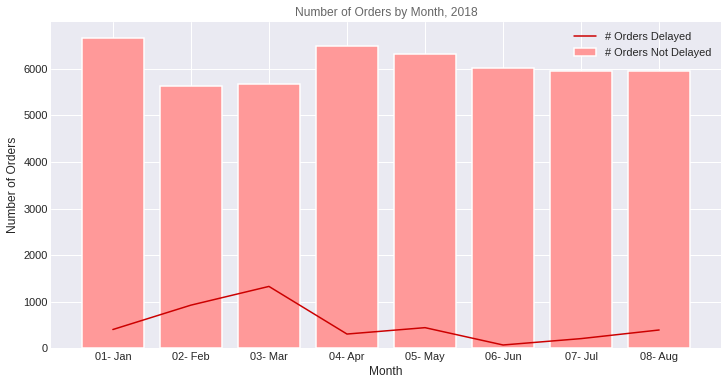

In [19]:
from matplotlib import pyplot
fig = plt.figure(figsize=(12,6))
df_final2 = df_final[df_final['OPT_YEAR']==2018]
df = df_final2.groupby(['Month','delayed']).agg({'order_id': 'nunique'}).unstack()
plt.style.use('seaborn-darkgrid')

fig = pyplot.figure(1, figsize=(16,6), dpi=90)
ax = fig.add_subplot(111)

X = df.reset_index()[(     'Month','')]
#X = df.reset_index()['OPT_MONTH']
C, S = df[('order_id', 0)], df[('order_id', 1)]

# Graficar revenue
plt.bar(X, C, color="#ff9999", linewidth=1.5, linestyle="-", label='# Orders Not Delayed'),
# Graficar revenue
plt.plot(X, S, color="#CC0000", linewidth=1.5, linestyle="-", label='# Orders Delayed')

plt.legend(loc='upper right')
plt.title("Number of Orders by Month, 2018", loc='center', fontsize=12, fontweight=0, color='#666666')
plt.xlabel("Month")
plt.ylabel("Number of Orders");


When going into detail of the previous chart, this one shows that in 2018, **March** was the month were around 25% of the orders were delayed.

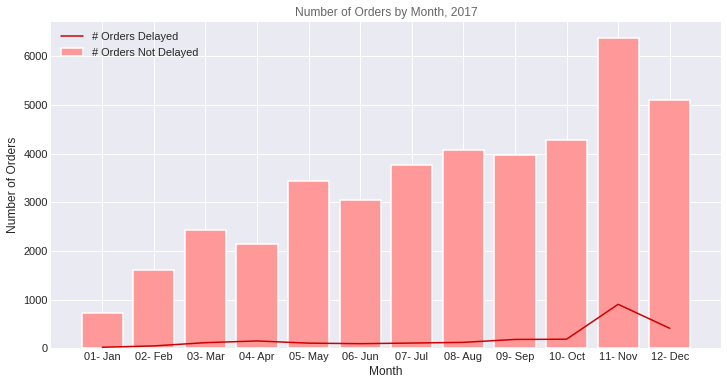

In [20]:
from matplotlib import pyplot
fig = plt.figure(figsize=(12,6))
df_final2 = df_final[df_final['OPT_YEAR']==2017]
df = df_final2.groupby(['Month','delayed']).agg({'order_id': 'nunique'}).unstack()
plt.style.use('seaborn-darkgrid')

fig = pyplot.figure(1, figsize=(16,6), dpi=90)
ax = fig.add_subplot(111)

X = df.reset_index()[(     'Month','')]
#X = df.reset_index()['OPT_MONTH']
C, S = df[('order_id', 0)], df[('order_id', 1)]

df_final = df_final.drop('Month', axis=1)

# Graficar revenue
plt.bar(X, C, color="#ff9999", linewidth=1.5, linestyle="-", label='# Orders Not Delayed'),
# Graficar revenue
plt.plot(X, S, color="#CC0000", linewidth=1.5, linestyle="-", label='# Orders Delayed')

plt.legend(loc='upper left')
plt.title("Number of Orders by Month, 2017", loc='center', fontsize=12, fontweight=0, color='#666666')
plt.xlabel("Month")
plt.ylabel("Number of Orders");

Making focus on 2017, **November** was the month were around 20% of the orders were delayed.